# Assignment 3 (100 points)

You are expected to complete this notebook with lines of code, plots and texts. You might need to create new cells with original code or text for your analyses. This assignment has a total of 100 points.

For assignment submission, you will submit this notebook file (.ipynb) on Canvas with cells executed and outputs visible. Your submitted notebook **must** follow these guidelines:
- No other dataset than the provided datasets should be used.
- Training, validation and testing splits should be the same as the ones provided.
- The cell outputs in your delivered notebook should be reproducible.
- Please print out the evaluation metric evidence that your model achieves the evaluation requirement. Optionally, you can also add plot of how the evaluation metric changes over the course of training process.
- Please provide code associated with the conclusions you make in your analysis as well as code that is used to generate plots, images, etc. for your analysis.
- All code must be your own work. Code cannot be copied from external sources or another students. You may copy code from cells that are pre-defined in this notebook if you think it is useful to reuse in another question.
- All images must be generated from data in your code. Do **NOT** import/display images that are generated outside your code.
- Your analyses must be your own, but if you quote text or equations from another source please make sure to cite the appropriate references.
- Your input with code will be marked with comments ``###your code starts here###`` and ``###your code ends here###`` to specify where you need to write your code. You can also create a new code cell in between those marked comments.


**NOTES:**
- PyTorch needs to be downloaded and installed properly.
- You should use PyTorch 1.7 or later.
- If you need to import a different package than the ones already imported, please check with the TA if you can do so.
- Cells should be run in order, using Shift+Enter.
- Read all the provided code cells and comments as they contain variables and information that you may need to use to complete the notebook.
- To create a new text cell, select "+" button on the menu bar and change its type from "Code" to "Markdown".
- To modify a text cell, double click on it.
- More details on how to format markdown text can be found here: https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed
- Your home directory on CADE machines has a small disk quota. It might be necessary, depending on how much your home directory is already occupied, to store the virtual environment inside a folder in ```/scratch/tmp/```. 

**Tips for training deep learning models:**
- We assume a GPU of at least 4GB of memory is available. If you want to try running the assignment with a GPU that has less than that, you can try changing the argument passed when calling the ```define_gpu_to_use``` function.  If you are getting out-of-memory errors for the GPU, you may want to check what is occupying the GPU memory by using the command ```!nvidia-smi```, which gives a GPU's usage report. However, if you are using your own Windows machine, the nvidia-smi command used in the define_gpu_to_use function will not work. You can skip running this function but please check to make sure your GPU has a sufficient amount of free memory.
- Here are a few PyTorch details not to forget:
    - Toggle train/eval mode for your model
    - Reset the gradients with ```zero_grad()``` before each call to ```backward()```
    - Check if the loss you are using receives logits or probabilities, and adapt your model output accordingly.
    - Reinstantiate your model every time you are starting a new training so that the weights are reset, if you plan to reuse the variable name.
    - Pass the model's parameters to the optimizer.

# Exercise 0 - Setting-up Infrastructure (Total of 0 points)
## + Installing Libraries:
Follow the steps below to install a few more additional libraries:
- Open another terminal and activate your virtual environment ``source your_virtualvenv_name/bin/activate``.
- Install the following libraries via pip using these commands: ``pip install scikit-imag``, ``pip install scikit-learn``, ``pip install imageio``, and ``pip install imagecodecs``.

## + Importing Libraries:

In [1]:
import os
import gzip
import shutil
import tarfile
import imageio
import imagecodecs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import zipfile
import collections
from skimage import morphology
from skimage.measure import block_reduce
import scipy
from torch.utils.data import Dataset
import PIL
from PIL import Image
from sklearn.metrics import f1_score
import copy
import random
import math
import torch
from packaging import version

##### Checking Torch library requirement #####
my_torch_version = torch.__version__
minimum_torch_version = '1.7'
if version.parse(my_torch_version) < version.parse(minimum_torch_version):
    print('Warning!!! Your Torch version %s does NOT meet the minimum requirement!\
            Please update your Torch library\n' %my_torch_version)

## + Requesting GPU Usage:

In [2]:
##### Checking the System #####
try:
    hostname = !hostname
    if 'lab' in hostname[0] and '.eng.utah.edu' in hostname[0]:
        IN_CADE = True
    else:
        IN_CADE = False
except:
    IN_CADE = False
    
##### Requesting a GPU #####
## This function locates an available gpu for usage. In addition, this function reserves a specificed
## memory space exclusively for your account. The memory reservation prevents the decrement in computational
## speed when other users try to allocate memory on the same gpu in the shared systems, i.e., CADE machines. 
## Note: If you use your own system which has a GPU with less than 4GB of memory, remember to change the 
## specified mimimum memory.
def define_gpu_to_use(minimum_memory_mb = 3500):    
    thres_memory = 600 #
    gpu_to_use = None
    try: 
        os.environ['CUDA_VISIBLE_DEVICES']
        print('GPU already assigned before: ' + str(os.environ['CUDA_VISIBLE_DEVICES']))
        return
    except:
        pass
    
    torch.cuda.empty_cache()
    for i in range(16):
        free_memory = !nvidia-smi --query-gpu=memory.free -i $i --format=csv,nounits,noheader
        if free_memory[0] == 'No devices were found':
            break
        free_memory = int(free_memory[0])
        
        if free_memory>minimum_memory_mb-thres_memory:
            gpu_to_use = i
            break
            
    if gpu_to_use is None:
        print('Could not find any GPU available with the required free memory of ' + str(minimum_memory_mb) \
              + 'MB. Please use a different system for this assignment.')
    else:
        os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_to_use)
        print('Chosen GPU: ' + str(gpu_to_use))
        x = torch.rand((256,1024,minimum_memory_mb-thres_memory)).cuda()
        x = torch.rand((1,1)).cuda()        
        del x
        
## Request a gpu and reserve the memory space
define_gpu_to_use()

Chosen GPU: 0


# Exercise 1 - DRIVE and STARE Dataset (100 points)

In this exercise, we are going to implement a segmentation model to extract blood vessels in retinal digital images. We will utilize two well-known retina image datasets, DRIVE (https://www.isi.uu.nl/Research/Databases/DRIVE/) and STARE (http://cecas.clemson.edu/~ahoover/stare/). First, we need to download these datasets. Please follow the steps below to download the images and then put them in the same directory as this notebook:
 - Register an account with DRIVE dataset - https://grand-challenge.org/accounts/login/?next=https%3A//drive.grand-challenge.org/participants/registration/create/
 - Download ``datasets.zip`` file at https://drive.grand-challenge.org/Download/
 - Download ``stare-images.tar`` from http://cecas.clemson.edu/~ahoover/stare/probing/stare-images.tar
 - Download ``labels-vk.tar`` from http://cecas.clemson.edu/~ahoover/stare/probing/labels-vk.tar

Next, we are going to define a few functions to extract images from the downloaded file for DRIVE and STARE datasets, respectively.

In [3]:
##### Removing Small Regions #####
## This function removes small regions (<size) of a given binary image.
def remove_small_regions(img, size):
    img = morphology.remove_small_objects(img, size)
    img = morphology.remove_small_holes(img, size)
    return img

In [4]:
##### Resizing Image #####
## This function resizes a given input image to be half of the original size.
def resize_img(img):
    if len(img.shape)==3:
        img = np.array(Image.fromarray(img).resize(((img.shape[1]+1)//2,(img.shape[0]+1)//2), \
                                                   PIL.Image.BILINEAR))
    else:
        img = block_reduce(img, block_size=(2, 2), func=np.max)
    return img

In [5]:
##### DRIVE Dataset Loading Function #####
## This function unzips the downloaded file. Then, it loads the corresponding mask 
## for each image in the DRIVE dataset.
def drive_read_images(filetype, dest_folder):
    zip_ref = zipfile.ZipFile('datasets.zip', 'r')
    zip_ref.extractall('datasets/drive')
    zip_ref.close()
    zip_ref = zipfile.ZipFile('datasets/drive/training.zip', 'r')
    zip_ref.extractall('datasets/drive')
    zip_ref.close()
    #zip_ref = zipfile.ZipFile('datasets/drive/test.zip', 'r')
    #zip_ref.extractall('datasets/drive')
    #zip_ref.close()
    all_images = []
    for item in sorted(os.listdir(dest_folder)):
        if item.endswith(filetype):            
            img = imageio.imread(dest_folder + item)
            if len(img.shape) == 3:
                img = np.pad(img , ((12,12), (69,70),(0,0)), mode = 'constant')
            else:
                img = np.pad(img , ((12,12), (69,70)), mode = 'constant')
            img = resize_img(img)
            img = img/255.
            img = img.astype(np.float32)
            if len(img.shape) == 2:
                img = img.astype(np.float32)
                img = np.expand_dims(img, axis = 2)
            all_images.append(img)
    return all_images

In [6]:
##### STARE Dataset Loading Function #####
## This function untars the downloaded file. Then, it loads the corresponding mask 
## for each image in the STARE dataset.
def stare_read_images(tar_filename, dest_folder, do_mask = False):
    tar = tarfile.open(tar_filename)
    tar.extractall(dest_folder)
    tar.close()
    all_images = []
    all_masks = []
    for item in sorted(os.listdir(dest_folder)):
        if item.endswith('gz'):
            with gzip.open(dest_folder + item, 'rb') as f_in:
                with open(dest_folder + item[:-3], 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
            os.remove(dest_folder + item) 
            img = imageio.imread(dest_folder + item[:-3])
            if len(img.shape) == 3:
                img = np.pad(img , ((1,2), (2,2),(0,0)), mode = 'constant')
            else:
                img = np.pad(img , ((1,2), (2,2)), mode = 'constant')
            img = resize_img(img)
            img = img/255.
            img = img.astype(np.float32)
            if len(img.shape) == 2:
                img = img.astype(np.float32)
                img = np.expand_dims(img, axis = 2)
            all_images.append(img)
            if do_mask:
                mask = (1-remove_small_regions(np.prod((img<50/255.)*1.0, axis = 2)>0.5, 1000))*1.0
                mask = np.expand_dims(mask, axis = 2)
                all_masks.append(mask.astype(np.float32))
    if do_mask:
        return all_images, all_masks
    else:
        return all_images

The DRIVE dataset provides its own split for training and testing. However, the mask images of the test split in DRIVE dataset are currently missing. Thus, we are going to use our own train/validation/test splits with the provided function below. 

In [7]:
##### Spliting a dataset for training, validatation, and testing #####
## This function splits a given dataset into 3 subsets of 70%-10%-20% for train-val-test, 
## respectively, and is used internally in the dataset classes below.
def get_split(array_to_split, split):
    np.random.seed(0)
    np.random.shuffle(array_to_split)
    np.random.seed()
    if split == 'train':
        array_to_split = array_to_split[:int(len(array_to_split)*0.7)]
    elif split == 'val':
        array_to_split = array_to_split[int(len(array_to_split)*0.7):int(len(array_to_split)*0.8)]
    elif split == 'test':
        array_to_split = array_to_split[int(len(array_to_split)*0.8):]
    return array_to_split

## Exercise 1.1 - Data Augmentation (20 points)
Data augmentation is an essential step in training deep models. Using data augmentation usually helps to improve the performance of a deep model. Please write a short reasoning why data augmentation helps to improve the performance.

**Write your answer here:** Getting data for training is an time extensive and expensive process and we know that we our dataset is too small then it won't generalize well and can easily lead to overfitting, in data augmentation one artificially creates new data using some modifications done to existing training data, this increases the size of training data and introduces the variablility hence prevents overfitting.

For this exercise, we will be using horizontal and vertical flipping. Your task is first to provide a short reasoning why horizontal and vertical flipping is suitable for this dataset. Second, please list at least one other data augmentation method that could also be used for this dataset. 

**Write your answer here:** Horizontal and vertical flipping are the most common data augmentation techniques used for images, the dataset given is an retinal image dataset, depending on how the images are taken they can have a vertical or horizontal flip, also horizontal and vertical flip applies transfromation without losing important information in images, hence they can be used.
Apart for then I think rotation or scaling and an augmentation technique could also be used for the dataset.

Next, you will implement the horizontal and vertical flipping transformations by filling out the missing codes in the code cell below. 

In [8]:
##### Defining Transformations #####
## The transformations below will be applied to input image, segmentation ground-truth and mask.

## Applying transformations to all array in list x 
def _iterate_transforms(transform, x):
    for i, xi in enumerate(x):
        x[i] = transform(x[i])
    return x

## Redefining Pytorch composed transform so that it uses the _iterate_transforms function
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, x):
        for transform in self.transforms:
            x = _iterate_transforms(transform, x) 
        return x

## Generating randomize odd for vertical flipping class
class RandomVerticalFlipGenerator(object):
    def __call__(self, img):
        self.random_n = random.uniform(0, 1)
        return img

## Performing vertical flip using randomization provided by generator class above
class RandomVerticalFlip(object):
    def __init__(self, gen):
        self.gen = gen

    def __call__(self, img):
        if self.gen.random_n < 0.5:
            ### Your code starts here ###
            flipped_img = torch.flip(img, (1,))
            ### Your code ends here ###
            return flipped_img
        return img

## Generating randomize odd for horizontal flipping class  
class RandomHorizontalFlipGenerator(object):
    def __call__(self, img):
        self.random_n = random.uniform(0, 1)
        return img

## Performing horizontal flip using randomization provided by generator class above
class RandomHorizontalFlip(object):
    def __init__(self, gen):
        self.gen = gen

    def __call__(self, img):
        if self.gen.random_n < 0.5:
            ### Your code starts here ###
            flipped_img = torch.flip(img, (2,))
            ### Your code ends here ###
            return flipped_img
        return img 

We then create a Pytorch class structure for this dataset. The dataset class is used to load, index, and preprocess samples for training, validation, and testing process.

In [9]:
class RetinaDataset(Dataset):    
    ##### Initializing the class #####
    def __init__(self, retina_array, split = 'train', do_transform=False):
        ## Split parameter is used to specify which process the data is used for,
        ## and it can be 'train', 'val', and 'test'
        indexes_this_split = get_split(np.arange(len(retina_array), dtype = int), split)
        self.retina_array = [self.transpose_first_index(retina_array[i]) for i in indexes_this_split]
        self.split = split
        self.do_transform = do_transform
        
    ##### Retrieving a sample with the corresponding index #####
    ## This function retrieve a sample from the dataset at the specified index 
    ## and returns a list in which the first element is input image to be segmented,
    ## the second element is the segmentation ground truth, and the last element is the mask of image region
    def __getitem__(self, index):
        sample = [torch.FloatTensor(x) for x in self.retina_array[index]]
        if self.do_transform:
            v_gen = RandomVerticalFlipGenerator()
            h_gen = RandomHorizontalFlipGenerator()
            t = Compose([
                v_gen,
                RandomVerticalFlip(gen=v_gen),
                h_gen,
                RandomHorizontalFlip(gen=h_gen),
            ])
            sample = t(sample)
        return sample
    
    ##### Accessing the length of the dataset #####
    def __len__(self):
        return len(self.retina_array)
    
    ##### Flipping the third dimension #####
    def transpose_first_index(self, x):
        x2 = (np.transpose(x[0], [2,0,1]), np.transpose(x[1], [2,0,1]), np.transpose(x[2], [2,0,1]))
        return x2

Now, we utilize the class function above to create structures for each training, validation, and test set.

In [10]:
##### Loading Data #####
## This function loads DRIVE and STARE datasets into a list of list of arrays. 
## The first element in the list is the list of input images, the second element is a list of segmentation
## ground truth, and the last element is a list of masks of image region.
## The original images were padded as squares so that we can fit them to a traditional CNN. 
## The masks are binary images, and contain the location of the original image (labeled as 1) and 
## the padded region (labeled as 0). These masks are used to limit where outputs are backpropagated 
## for trained and which region of the image should be used for scoring. 
def get_retina_array():
    stare_images, stare_mask = stare_read_images("stare-images.tar", 'datasets/stare/images/', do_mask = True)  
    stare_segmentation = stare_read_images("labels-vk.tar", 'datasets/stare/segmentations/')   
    drive_training_images = drive_read_images('tif', 'datasets/drive/training/images/')
    #drive_test_images = drive_read_images('tif', 'datasets/drive/test/images/')
    drive_training_segmentation = drive_read_images('gif', 'datasets/drive/training/1st_manual/')
    #drive_test_segmentation = drive_read_images('gif', 'datasets/drive/test/1st_manual/')
    drive_training_mask = drive_read_images('gif', 'datasets/drive/training/mask/')
    #drive_test_mask = drive_read_images('gif', 'datasets/drive/test/mask/')
    return list(zip(stare_images+drive_training_images,#+drive_test_images, 
                           stare_segmentation+drive_training_segmentation,#+drive_test_segmentation, 
                           stare_mask + drive_training_mask))# + drive_test_mask))

In [11]:
retina_array = get_retina_array()

train_dataset = RetinaDataset(retina_array, do_transform = True)
val_dataset = RetinaDataset(retina_array, split = 'val')
test_dataset = RetinaDataset(retina_array, split = 'test')

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

/tmp/ipykernel_32496/1591849145.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(dest_folder + item[:-3])
/tmp/ipykernel_32496/3635158150.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(dest_folder + item)


Let's visulize a few samples to get ourselves familiar with the type of images we are working with in this exercise. 

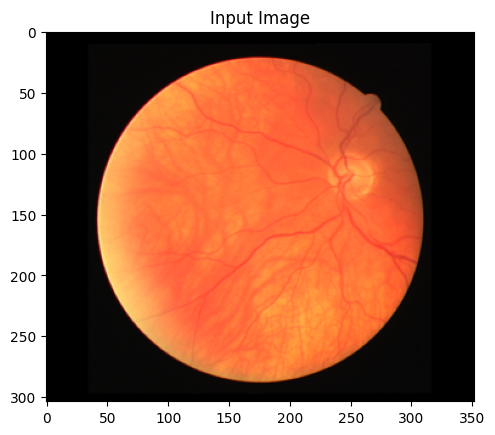

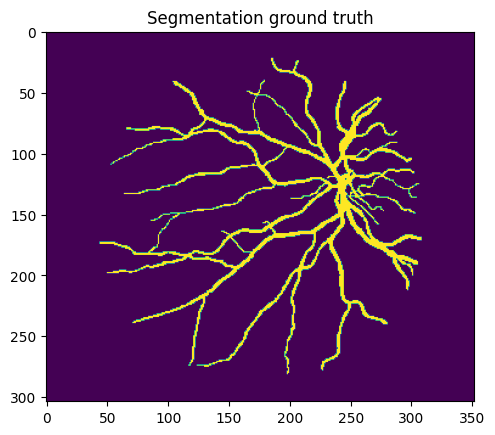

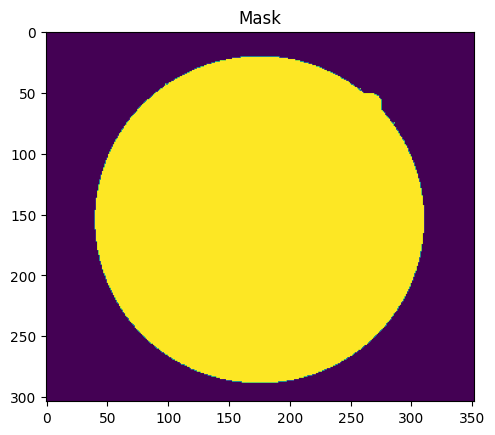

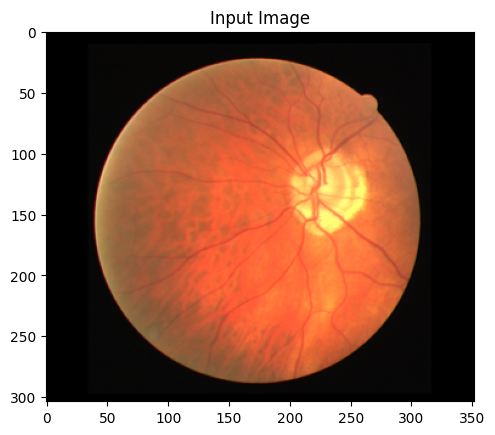

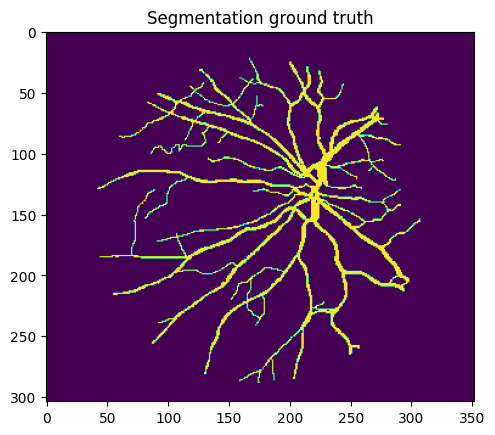

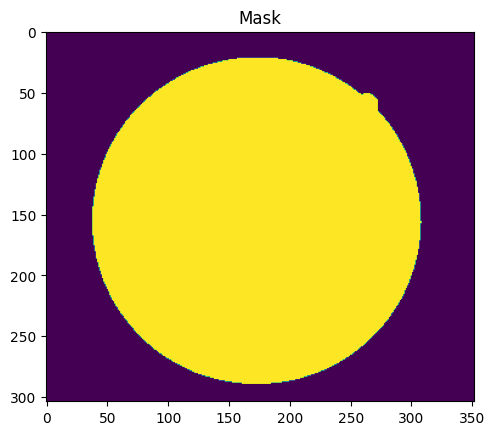

In [12]:
## Visualing a few cases in the training set
for batch_idx, (data, segmentation, mask) in enumerate( RetinaDataset(retina_array)):
    if batch_idx%15 == 0: 
        plt.figure()
        plt.title("Input Image")
        plt.imshow(data[:,:,:].permute([1,2,0]).cpu().numpy())
        plt.figure()
        plt.title("Segmentation ground truth")
        plt.imshow(segmentation[0,:,:].cpu().numpy())
        plt.figure()
        plt.title("Mask")
        plt.imshow(mask[0,:,:].cpu().numpy())
    

We are going to use F1 score to evaluate the segmentation results. The F1 score is computed from precision and recall, and has value between 0 (the worst possible value) and 1 (the best possible value). More information about F1 score can be found here - https://en.wikipedia.org/wiki/F-score. For this exercise, we consider the foreground as positive class and the background as negative class in computing F1 score. 

In [13]:
##### Calculating F1 metric #####
def get_score_model(model, data_loader):
    ## Toggling model to eval mode
    model.eval()
    
    ## Turning off gradients
    with torch.no_grad():
        logits_predicted = np.zeros([0, 1, 304, 352])
        segmentations = np.zeros([0, 1, 304, 352])
        
        mean_f1 = 0.0
        ## Iterating through the dataset and perform inference for each sample.
        ## Then, the F1 score is computed for each sample. 
        for image, segmentation, mask  in data_loader:
            image = image.cuda()
            logit_predicted = model(image)
            logit_predicted = logit_predicted.cpu().detach().numpy()*mask.numpy()
            segmentation = segmentation.numpy()*mask.numpy()
            
            ## Computing F1 score for each sample in the batch
            for i in range(segmentation.shape[0]):
                curr_seg = segmentation[i,...].reshape([-1])
                curr_logit = logit_predicted[i,...].reshape([-1]) > 0
                curr_f1 = f1_score(curr_seg, curr_logit)
                mean_f1 += curr_f1
                
    ## Returning the mean F1 of the entire dataset
    return mean_f1/len(data_loader.dataset)

## Exercise 1.2 - Computing Weight Vector (10 points)
In many real world applications, the dataset tends to be imbalanced. It is also the case for this retina image dataset. In this dataset, there are more background samples than there are foreground samples. In this exercise, your task is to examine the imbalanced between foreground and background by providing the following analyses:
- The percentage of positive label (foreground) in this dataset.
- The ratio of negative label (background) to positive label (foreground). 

In [14]:
### Your code starts here ###
ratio_list = []

for i in range(len(train_dataset.retina_array)):
    image, segmentation, mask = train_dataset.retina_array[i]
    idx = np.where(segmentation != 0)
    ratio = idx[1].shape[0]/np.prod(segmentation.shape)
    ratio_list.append(ratio)

avg_positive_ratio = np.mean(np.array(ratio_list))

print(f'Percent of postive label = {avg_positive_ratio*100} and ratio of negative labels to positive label = {(1-avg_positive_ratio)/avg_positive_ratio}')

### Your code ends here ###

Percent of postive label = 11.599499903879016 and ratio of negative labels to positive label = 7.621061324079908


- The percentage of positive label (foreground): 11.5999
- The ratio of negative label (background) to positive label (foreground): 7.621

Now, we are going to use the ratio of negative label to positive label as weight vector for the loss function. In the code cell below, please provide an implementation of a weighted loss function for a binary classification problem.

In [15]:
### Your code starts here ###

### Weighted implementation of BCEWithLogits from pytorch, sigmoid combined with loss for better stability    
class Weighted_BCE(torch.nn.Module):
    def __init__(self, weight, epsilon=1e-7):
        super(Weighted_BCE, self).__init__()
        self.epsilon = epsilon
        self.weight = weight
        self.sigmoid = torch.nn.Sigmoid()


    def forward(self, predicted, target):
        result = - ((self.weight * target * torch.log(self.sigmoid(predicted)+self.epsilon)) + ( (1-target) * torch.log(1-self.sigmoid(predicted)+self.epsilon)))
        return torch.mean(result)
    
ratio = (1-avg_positive_ratio)/avg_positive_ratio
loss = Weighted_BCE(weight=ratio)
loss.to('cuda:0')
### Your code ends here ###

Weighted_BCE(
  (sigmoid): Sigmoid()
)

## Exercise 1.3 - Implementing U-Net (60 points)
In this section, you are going to implement a well-known segmentation model, called U-Net. Your implementation should follow the architecture as described in the paper (https://arxiv.org/pdf/1505.04597.pdf - Fig. 1 and Section 2) with a few modifications below:
- The input should have 3 channels, and the output should have only one channel (binary output).
- Adding 2D batch normalization layer between convolution layer and Relu transformation, i.e., changing CONV->RELU to CONV->BN->RELU.
- Padding the convolution layers so that the outputs of the convolution layers have the same spatial size as the inputs. With this modification, the cropping operation before the concatenation in the skip connection can be removed.
- Upsampling operation should be implemented with the torch.nn.ConvTransposed2D layer. More details to understand what they meant in the paper can be found in the video here (https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) starting at 2:22.
- Reducing the number of channels of **ALL** internal layers 4 times. For example, the number of channels in the first convolution layer in the paper is 64. The first convolution layer in your implementation should have 16 channels instead. 
- No need to implement the initialization of weights as described in the paper. The default weight initialization from Pytorch is sufficient. 
- Your U-Net implementation should be named ``model_ex13`` and the best model should be called ``best_model_ex13``.
- Your implementation of U-Net should achieve F1 score of at least 0.75 on the validation set.

In [16]:
### Your code starts here ###
import torch.nn as nn

class SingleBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SingleBlock, self).__init__()
            
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        return self.double_conv(x)

class EncoderModule(nn.Module):
    def __init__(self, in_channels, features):
        super(EncoderModule, self).__init__()
        self.encoder_steps = nn.ModuleList()
        for ft in features:
            self.encoder_steps.append(SingleBlock(in_channels=in_channels, out_channels=ft))
            in_channels = ft
            
        self.pooling = nn.MaxPool2d(kernel_size=2)
        
    def forward(self, x):
        encoders_features = []
        for down in self.encoder_steps:
            x = down(x)
            encoders_features.insert(0, x)
            x = self.pooling(x)
        return x, encoders_features
        
class DecoderModule(nn.Module):
    def __init__(self, out_channels, features):
        super(DecoderModule, self).__init__()
        self.decoder_steps = nn.ModuleList()
        self.upconv = nn.ModuleList()

        for ft in reversed(features):
            self.upconv.append(nn.ConvTranspose2d(ft*2, ft, kernel_size=2, stride=2))
            self.decoder_steps.append(SingleBlock(in_channels=ft*2, out_channels=ft))

        self.final_layer = nn.Conv2d(ft, out_channels, 1, bias=False)
        
        
    def forward(self, x, encoders_features):
        for i in range(len(encoders_features)):
            x = self.upconv[i](x)
            concat_x = torch.cat((encoders_features[i], x), dim=1)
            x = self.decoder_steps[i](concat_x)
        x=self.final_layer(x)
        return x

class UNET_Module(nn.Module):
    def __init__(self, in_channels, out_channels, f_maps=16, num_levels=5):
        super(UNET_Module, self).__init__()
        features = [f_maps*(2**i) for i in range(num_levels)]
        self.encoder = EncoderModule(in_channels=in_channels, features=features[:-1]) 
        self.decoder = DecoderModule(out_channels=out_channels, features=features[:-1])
        self.bottleneck = SingleBlock(in_channels=features[-2], out_channels=features[-1])
        
    def forward(self, x):
        x, encoders_features = self.encoder(x)
        x = self.bottleneck(x)
        x = self.decoder(x, encoders_features)
        return x

DEVICE = "cuda:0"
model_ex13 = UNET_Module(in_channels=3, out_channels=1, f_maps=16)
model_ex13.to(DEVICE)


# ### For testing only
# inp = torch.zeros(1, 3, 304, 352).to(DEVICE).float()
# out = model_ex13(inp)
### Your code ends here ###

UNET_Module(
  (encoder): EncoderModule(
    (encoder_steps): ModuleList(
      (0): SingleBlock(
        (double_conv): Sequential(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
      )
      (1): SingleBlock(
        (double_conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(32, e

Next, your task is to complete the ``training_stage`` function below. You must use the provided masks when computing the loss. In other words, you must only compute the loss for the pixels that have values of 1 in the corresponding mask images.

In [17]:
def training_stage(epoch, optimizer, loss, model, train_loader, val_loader):
    model.train()
    loss_values = []
    for batch_idx, (data, segmentation, mask) in enumerate(train_loader):
        ### Your code starts here ###
        optimizer.zero_grad()
        data = data.to(DEVICE)
        segmentation = segmentation.to(DEVICE)
        mask = mask.to(DEVICE)
        ### This will mask only the required region and pass gradients only for them
        predicted = model(data) * mask
        segmentation = segmentation * mask
        loss_value = loss(predicted, segmentation)
        loss_value.backward()
        optimizer.step()
        ### Your code ends here ###
        loss_values.append(loss_value.item())
    return np.mean(loss_values)

In [18]:
optimizer = torch.optim.SGD(model_ex13.parameters(), lr=0.01, momentum=0.9, nesterov=True)
n_epochs = 200

## Using the scheduler module to reduce the learning rate after reaching a plateau. 
## More information about the scheduler can be found at 
## https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.1)
current_best_score = -1

for epoch in range(n_epochs):
    ## Train the model
    loss_value = training_stage(epoch, optimizer, loss, model_ex13, train_loader, val_loader)
    ## Evaluate the current model
    f1_val = get_score_model(model_ex13, val_loader)
    f1_train = get_score_model(model_ex13, train_loader)
    current_score = f1_val
    ## Save the model
    if current_score > current_best_score:
        current_best_score = current_score
        best_model_ex13 = copy.deepcopy(model_ex13)
    print('Train Epoch: {:d} \tLoss: {:.5f}'.format(epoch,loss_value))
    print('F1 train: {:.5f} \t F1 val: {:.5f}'.format(f1_train, f1_val))
    ## Activate scheduler
    scheduler.step()

Train Epoch: 0 	Loss: 1.18262
F1 train: 0.30466 	 F1 val: 0.32971
Train Epoch: 1 	Loss: 1.13213
F1 train: 0.30466 	 F1 val: 0.32971
Train Epoch: 2 	Loss: 1.08887
F1 train: 0.30466 	 F1 val: 0.32971
Train Epoch: 3 	Loss: 1.03082
F1 train: 0.30614 	 F1 val: 0.33072
Train Epoch: 4 	Loss: 1.00119
F1 train: 0.32978 	 F1 val: 0.34249
Train Epoch: 5 	Loss: 0.99446
F1 train: 0.28532 	 F1 val: 0.29839
Train Epoch: 6 	Loss: 0.99033
F1 train: 0.32806 	 F1 val: 0.33867
Train Epoch: 7 	Loss: 0.96001
F1 train: 0.08554 	 F1 val: 0.05088
Train Epoch: 8 	Loss: 0.92127
F1 train: 0.44649 	 F1 val: 0.46515
Train Epoch: 9 	Loss: 0.88658
F1 train: 0.35566 	 F1 val: 0.36082
Train Epoch: 10 	Loss: 0.85320
F1 train: 0.58474 	 F1 val: 0.64320
Train Epoch: 11 	Loss: 0.83609
F1 train: 0.59888 	 F1 val: 0.66694
Train Epoch: 12 	Loss: 0.81038
F1 train: 0.51686 	 F1 val: 0.60550
Train Epoch: 13 	Loss: 0.80125
F1 train: 0.43770 	 F1 val: 0.50826
Train Epoch: 14 	Loss: 0.79432
F1 train: 0.40025 	 F1 val: 0.41503
Train

Lastly, let's evaluate the trained model on the test set.

In [19]:
print(f'Best F1 score of val set: {current_best_score}')
print('F1 score of test set: {:.5f}'.format(get_score_model(best_model_ex13, test_loader)))

Best F1 score of val set: 0.8073320780977675
F1 score of test set: 0.76955


## Exercise 1.4 - Visualizing Output (10 points)
In this section, please plot the predicted output of a few samples from the validation set as well as the corresponding ground-truth. In addition, please provide a short analysis on the type of mistakes that you are able to distinguish. For example, where in the image does the model wrongly identify as foreground? where in the image does the model wrongly identfy as background?

**Write your analysis here**: Looking at the outputs one can see than for the boundary region around mask it is identifying wrongly as the foreground (white circular tint over mask boundary), and when there are very fine structures it wrongly identifies it as background, some tiny blood vessels are not being identified and even the idetified one don't have proper structure.

<Figure size 640x480 with 0 Axes>

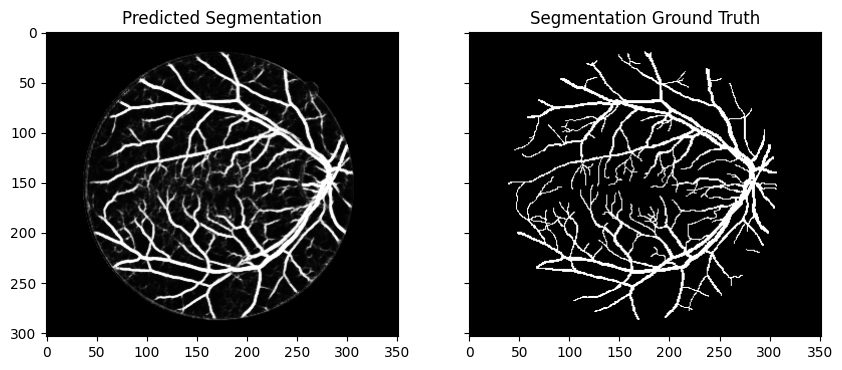

<Figure size 640x480 with 0 Axes>

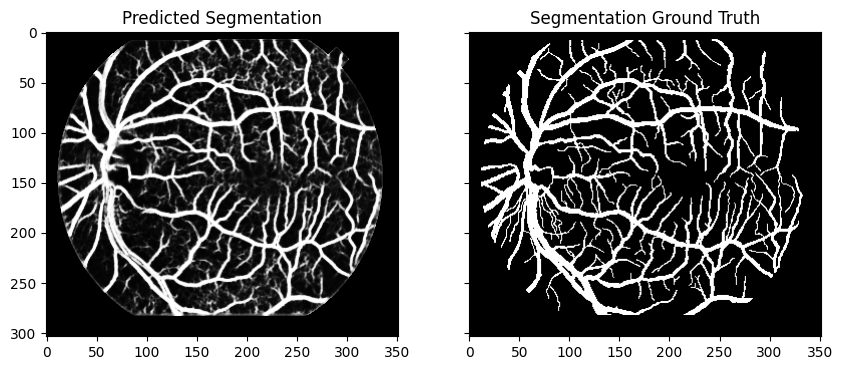

<Figure size 640x480 with 0 Axes>

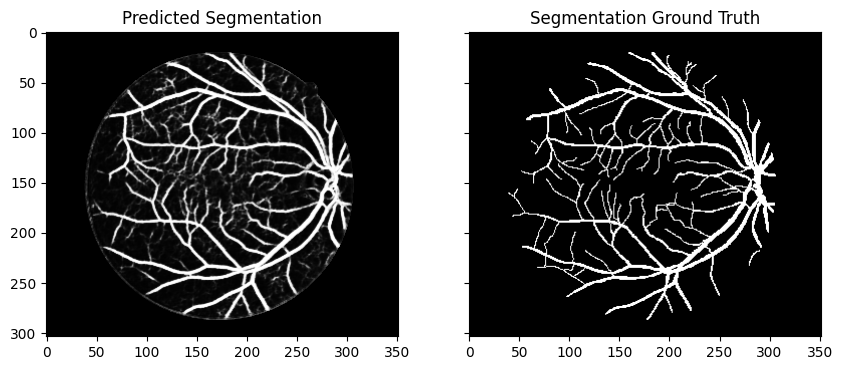

<Figure size 640x480 with 0 Axes>

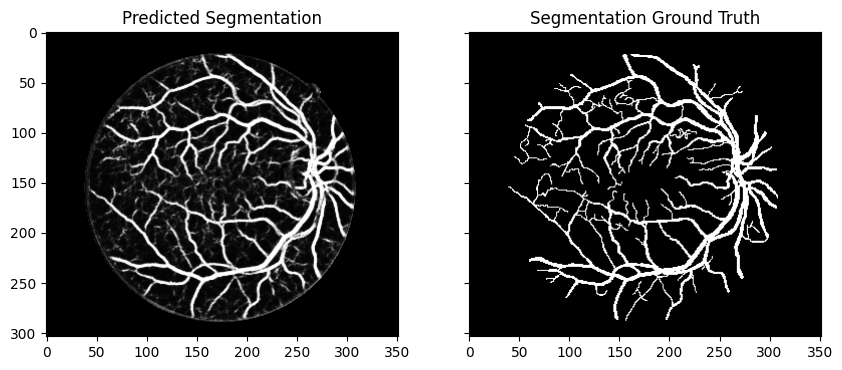

In [20]:
### Your code starts here ###
for batch_idx, (data, segmentation, mask) in enumerate(val_loader):
    if batch_idx%1 == 0: 
        data = data.to(DEVICE)
        segmentation = segmentation.to(DEVICE)
        mask = mask.to(DEVICE)
        predicted = best_model_ex13(data)
        predicted = torch.sigmoid(predicted)
        predicted = predicted *  mask
        segmentation = segmentation * mask
        plots = []
        plt.figure()
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 10))
        ax1.imshow(predicted[0,:,:].detach().squeeze().cpu().numpy(), cmap='gray')
        ax1.set_title("Predicted Segmentation")
        ax2.imshow(segmentation[0,:,:].detach().squeeze().cpu().numpy(), cmap='gray')
        ax2.set_title("Segmentation Ground Truth")
### Your code ends here ###